# Social Networks - Assignment 1

This **Home Assignment** is **mandatory**, it does count towards your final chance to take part in the exam. This assignment covers sampling from Gnp models as well as efficient data structures used to represent graphs.

You can expect numpy and networkx to be installed.

## Formalities

**Submit in a group of 3-4 people until 12.05.2022 23:59CET. The deadline is strict!**

You have the opportunity for an prelim submission until 08.05.2022 23:59 CET. We will run your code once, and you can thus see whether there are small bugs that you might not have expected.

## Evaluation and Grading
General advice for programming excercises at *CSSH*:
Evaluation of your submission is done semi-automatically. Think of it as this notebook being 
executed once. Afterwards, some test functions are appended to this file and executed respectively.

Therefore:
* Submit valid _Python3_ code only!
* Use external libraries only when specified by task.
* Ensure your definitions (functions, classes, methods, variables) follow the specification if
  given. The concrete signature of e.g. a function usually can be inferred from task description, 
  code skeletons and test cases.
* Ensure the notebook does not rely on current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
* Keep your code idempotent! Running it or parts of it multiple times must not yield different
  results. Minimize usage of global variables.
* Ensure your code / notebook terminates in reasonable time.

**There's a story behind each of these points! Don't expect us to fix your stuff!**

Regarding the scores, you will get no points for a task if:
- your function throws an unexpected error (e.g. takes the wrong number of arguments)
- gets stuck in an infinite loop
- takes much much longer than expected (e.g. >1s to compute the mean of two numbers)
- does not produce the desired output (e.g. returns an descendingly sorted list even though we asked for ascending, returns the mean and the std even though we asked for only the mean, prints an output instead of returning it!)

In [114]:
# credentials of all team members (you may add or remove members from the list)
team_members = [
    {
        'first_name': 'Supreet',
        'last_name': 'Sharma',
        'student_id': 416613
    },
    {
        'first_name': 'Chen',
        'last_name': 'Xu',
        'student_id': 414736
    },
    {
        'first_name': 'Samuel',
        'last_name': 'Kwong',
        'student_id': 430273
    },  
    {
        'first_name': 'Lorraine',
        'last_name': 'Saju',
        'student_id': 426927
    }  
]

# Task 1: Efficient sampling of planted partition models (12 points)

The overarching goal of this task is to implement a sampling procedure that allows to sample from a planted partition model in time linear to the number of edges in the partition model.

## Planted partition model  and  Stochastic block model (SBM)

In this course what is referred to as planted partition models is probably more widely known as [stochastic block models (SBMs)](https://en.wikipedia.org/wiki/Stochastic_block_model]). Wikipedia refers to planted partition models as a special case of SBMs where the probability matrix has only two values.

We are looking to generate those were the probability matrix is symmetric but can have more than two values.





### Preamble

Some utility functions

In [115]:
import numpy as np
print(np.__version__)# 1.22.3
assert np.__version__.startswith("1.22")
# it is important that you use the same numpy version as otherwise you will get different random number streams
# and thus none of the examples will look correct

1.22.3


In [116]:
from numpy.random import Generator, PCG64

def default_rng(i):
    return Generator(PCG64(i))

In [117]:
def to_array(E, n_rows, n_columns=None):
    """This function can be used to turn an edge list into a adjacency matrix, useful for visualization"""
    if n_columns is None:
        n_columns = n_rows

    A = np.zeros((n_rows, n_columns), dtype=int)
    for i,j in E:
        A[i,j]=1
        
    return A

In [118]:
def prepend_array(A):
    s=str(A)
    lines = ("# "+ s).splitlines()
    return "\n# ".join(lines)

### a) Warmup: Sampling 0-1 matrices where each element exists with fixed probability (3)

Use the idea of moving k-steps with a geometrically distributed step size to sample the nonzero elements of a 0-1 matrix. You have seen the trick of moving with geometrically distributed stepsize when discussing the efficient Gnp sampler. This task can be seen as a warmup for the next task which is to essentially implement the Gnp sampler. The shape of the matrix is `n_rows` by  `n_columns`. Notice though that you never actually construct this matrix. Each element in that matrix is 1 with probability `p` and 0 otherwise. To generate random numbers use `.geometric` of the passed in numpy generator sequence `rng`. The function steps through the matrix in a row first order.

Return the position of the nonzero elements of that matrix as a list of two-tuples.

In [119]:
def random_matrix(n_rows, n_columns, p, rng):
    E = []
    k = rng.geometric(p)
    w = -1 + k
    while w < n_rows * n_columns:
        i = w // n_columns
        j = w % n_columns
        v = (i,j)
        E.append(v)
        k = rng.geometric(p)
        w = w + k
    return E

In [120]:
def produce_example_output(n_rows, n_columns, p, seed, show_matrix=True):
    E=random_matrix(n_rows,n_columns, p, default_rng(seed))
    print("#", E)
    print(prepend_array(to_array(E, n_rows, n_columns)))

In [121]:
# full matrix
produce_example_output(2, 3, 1, 1)
# [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
# [[1 1 1]
#  [1 1 1]]

# [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
# [[1 1 1]
#  [1 1 1]]


In [122]:
# empty matrix
produce_example_output(2, 4, 0.3, 4)
# []
# [[0 0 0 0]
#  [0 0 0 0]]

# []
# [[0 0 0 0]
#  [0 0 0 0]]


In [123]:
# some other matrix
produce_example_output(2, 4, 0.5, 4)
# [(1, 0), (1, 2)]
# [[0 0 0 0]
#  [1 0 1 0]]

# [(1, 0), (1, 2)]
# [[0 0 0 0]
#  [1 0 1 0]]


In [124]:
%%time

# huge sparse matrix
E = random_matrix(100000,200000, 0.00001, default_rng(160))
print(len(E)) #199480

199480
CPU times: user 155 ms, sys: 18.7 ms, total: 174 ms
Wall time: 197 ms


### b) Gnp sampling with a twist (5)

In the lecture you have encountered the pseudocode for the Gnp sampler (see slides "Sampling efficiently from Gnp"). As seen in the illustrations that preceede the slide, this sampler traverses the lower triangular matrix in a row first fashion. This has the unfortunate side effect that the edges are not nicely ordered, in this task we will tackle this.

You task is to adapt the idea of implementing an efficient Gnp sampler which instead of traversing the lower triangle row first, traverses the **upper**  triangular matrix row first. The function produces an edgelist as result (a list of two-tuples of integers). Notice that now this edge list is sorted.

To generate random numbers use `.geometric` of the passed in numpy generator sequence `rng`.

Important note:
- Using the column first way on the lower triangle does not produce the same graph from the same random number state

In [125]:
def Gnp_row_first(n, p, rng):
    E = []
    pointer_u = -1
    pointer_v = 0
    k = rng.geometric(p)
    max_k = n*(n-1)/2
    steps = k
    while(pointer_u < n-2 and pointer_v < n and steps <= max_k):
        pointer = getNextEdgeUTM((pointer_u, pointer_v), k, n)
        pointer_u, pointer_v = pointer
        if(pointer_u < n and pointer_v < n):
            E.append(pointer)
            k = rng.geometric(p)
            steps += k
    return E

def getNextEdgeUTM(pointer, k, n):
    u, v = pointer
    tempCounter = 0
    if u < 0 and k > 0:
        u += 1
    if(v + k < n):
        v += k
    else:
        u += 1
        tempCounter += n - v
        v = u + 1
        if(k > tempCounter):
            return getNextEdgeUTM((u, v), k - tempCounter, n)
    newPointer = (u, v)
    return newPointer

In [126]:
print("# some generated graphs")
for i in range(10):
    rng1 = default_rng(i)
    E=Gnp_row_first(4, 0.8, rng1)
    print("#", E)

# some generated graphs 
# [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
# [(0, 1), (0, 3), (1, 2), (2, 3)]
# [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
# [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
# [(0, 2), (0, 3), (2, 3)]
# [(0, 2), (1, 2), (1, 3), (2, 3)]
# [(0, 1), (0, 2), (0, 3), (1, 2)]
# [(0, 1), (0, 3), (1, 2), (1, 3), (2, 3)]
# [(0, 1), (1, 2), (1, 3), (2, 3)]
# [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# some generated graphs
# [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
# [(0, 1), (0, 3), (1, 2), (2, 3)]
# [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
# [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
# [(0, 2), (0, 3), (2, 3)]
# [(0, 2), (1, 2), (1, 3), (2, 3)]
# [(0, 1), (0, 2), (0, 3), (1, 2)]
# [(0, 1), (0, 3), (1, 2), (1, 3), (2, 3)]
# [(0, 1), (1, 2), (1, 3), (2, 3)]
# [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [127]:
rng1 = default_rng(1074)
E=Gnp_row_first(4, 0.7, rng1) # []
print("# E", E)
assert len(E)==0
 # []

# E []


In [128]:
rng1 = default_rng(122)
E=Gnp_row_first(6, 0.3, rng1) # []
print("# E", E)
assert len(E)==0, E
# E []

# E []


In [129]:
rng1 = default_rng(16)
E = Gnp_row_first(4, 0.7, rng1) # full graph size 4
print("# E", E)
assert len(E)==6
# E [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


# E [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [130]:
rng1 = default_rng(160)
E=Gnp_row_first(6, 0.7, rng1) # full graph size 6
print("# E", E)
assert len(E)==15
# E [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


# E [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [131]:
%%time
# this should not blow up your RAM (full adjacency matrix as numpy ints uses 74.5 GiB; 10^10 entries)
# but there are only about 500_000 edges
# also this should run reasonably fast
E=Gnp_row_first(100000, 0.0001, default_rng(160))
print(len(E)) #499585

499585
CPU times: user 539 ms, sys: 15.2 ms, total: 554 ms
Wall time: 592 ms


### c) Sampling planted partition models (4)

We now combine the sampling functions from a) and b) to create a sampler that samples from a undirected simple planted partition model specified by the sizes of the partitions `ns` and the matrix `P` that specifies the edge probabilities. We sample the necessary sub-blocks in a row first fashion.

Pass the random state `rng` towards the functions from a) and b). P is a symmetric matrix.

In [132]:
def planted_partition(ns, P, rng):
    E=[]
    for row_idx, n_rows in enumerate(ns):
        for col_idx in range(0, row_idx + 1): #iterating only through the lower triangular matrix

            row_incr = sum(ns[0:row_idx])
            col_incr = sum(ns[0:col_idx])
#             print(f"Checking for p = {p} and matrix of dimensions:{n_rows, n_cols}")

            if(row_idx == col_idx): #for the diagonal
                new_edges = Gnp_row_first(n_rows, P[row_idx, col_idx], rng)
            else:
                new_edges = random_matrix(ns[col_idx], ns[row_idx], P[col_idx, row_idx], rng)
            E.extend([(x + col_incr, y + row_incr) for (x,y) in new_edges])
    return E

In [133]:
rng1 = default_rng(160)
pA=1
pB=0.7
pAB=0.5
P = np.array([[pA, pAB],[pAB,pB]])

print("P\n", P)
ns = [2,3]
all_edges = planted_partition(ns, P, rng1)

print("# edges", all_edges)
n=sum(ns)

print()
print("# as matrix")
print(prepend_array(to_array(all_edges, n, n)))
# edges [(0, 1), (0, 2), (0, 4), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

# as matrix
# [[0 1 1 0 1]
#  [0 0 0 1 1]
#  [0 0 0 1 1]
#  [0 0 0 0 1]
#  [0 0 0 0 0]]

P
 [[1.  0.5]
 [0.5 0.7]]
# edges [(0, 1), (0, 2), (0, 4), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

# as matrix
# [[0 1 1 0 1]
#  [0 0 0 1 1]
#  [0 0 0 1 1]
#  [0 0 0 0 1]
#  [0 0 0 0 0]]


In [134]:
rng1 = default_rng(160)
pA=0.8
pB=0.7
pC=0.6
pAB=0.3
pAC=0.1
pBC=0.2
P = np.array([[pA, pAB, pAC], [pAB,pB,pBC], [pAC,pBC,pC]])

print("P\n", P)
ns = [2,3,4]
all_edges = planted_partition(ns, P, rng1)

print("# edges", all_edges)
n=sum(ns)

print()
print("# as matrix")
print(prepend_array(to_array(all_edges, n, n)))
# edges [(0, 1), (0, 3), (2, 3), (2, 4), (3, 4), (1, 5), (2, 8), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (5, 8), (6, 7)]

# as matrix
# [[0 1 0 1 0 0 0 0 0]
#  [0 0 0 0 0 1 0 0 0]
#  [0 0 0 1 1 0 0 0 1]
#  [0 0 0 0 1 1 0 1 0]
#  [0 0 0 0 0 1 1 1 0]
#  [0 0 0 0 0 0 1 1 1]
#  [0 0 0 0 0 0 0 1 0]
#  [0 0 0 0 0 0 0 0 0]
#  [0 0 0 0 0 0 0 0 0]]

P
 [[0.8 0.3 0.1]
 [0.3 0.7 0.2]
 [0.1 0.2 0.6]]
# edges [(0, 1), (0, 3), (2, 3), (2, 4), (3, 4), (1, 5), (2, 8), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (5, 8), (6, 7)]

# as matrix
# [[0 1 0 1 0 0 0 0 0]
#  [0 0 0 0 0 1 0 0 0]
#  [0 0 0 1 1 0 0 0 1]
#  [0 0 0 0 1 1 0 1 0]
#  [0 0 0 0 0 1 1 1 0]
#  [0 0 0 0 0 0 1 1 1]
#  [0 0 0 0 0 0 0 1 0]
#  [0 0 0 0 0 0 0 0 0]
#  [0 0 0 0 0 0 0 0 0]]


# Task 2: Custom Graph datastructure (13 points)

Sometimes graph implementations can seem like magic, but they are usually quite simple. In this task, you are going to reimplement a graph structure that is very similar to the networkx graph interface. In fact it is so similar, that you can use it as a drop in replacement as a graph in many networkx functions which do not require node attributes.

We are striving for a graph representation that has space requirements linear in the number of nodes and and edges. In particular using an adjacency matrix as an internal representation is not acceptable. Otherwise to keep things simple we assume, that node labels are integers and thus they are also hashable.


### General remarks

In priciple writing your own Graph class is not really recommended. Networkx as an example provides some custom hints on how to properly inherit from their Graph class. But for the sake of learning it is actually quite interesting.

In [18]:
# in networkx you can do both G.edges and G.edges()
# to make that work some boilerplate code is required
# for the purpose of this assignment it is only necessary that you wrap the output of MyGraph.nodes and MyGraph.edges
# in this boilerplate class if you strive for network compatibility

class DummyView():
    def __init__(self, stuff):
        self.stuff = stuff

    def __call__(self, data=None, default=None):
        if data is None and default is None:
            return self
        elif isinstance(data, str):
            def add_default(tpl):
                return (*tpl, default)
            return DummyView(map(add_default, self.stuff))
        else:
            raise NotImplementedError

    def __len__(self):
        return len(self.stuff)
    
    def __iter__(self):
        return iter(self.stuff)
    
    def __str__(self):
        return f"Dummyview({str(self.stuff)})"
    def __repr__(self):
        return f"Dummyview({repr(self.stuff)})"

In [19]:
class MyGraph:
    def __init__(self):
        # list for nodes,edges
        self._nodes = []
        self._edges = []
        # self.neighbors = {}
        pass


### <--- node stuff  --->       
    def add_node(self, u):
        # check whether u in the nodes list, if not then add
        if u not in self._nodes:
            return self._nodes.append(u)
    
    def remove_node(self, u):
        # check whether u in the nodes list, if yes then remove
        if u in self._nodes:
            return self._nodes.remove(u)
    
    def has_node(self, u):
        return u in self._nodes
    
    def number_of_nodes(self):
        return len(self._nodes)
    
    @property
    def nodes(self):
        # wrapping return value in DummyView
        return DummyView(self._nodes)

    ### <--- edge stuff  --->   
    def add_edge(self, u, v):
        # check whether u,v in the nodes list, if not then add
        if ((u,v) in self._edges) or ((v,u) in self._edges):
            pass
        elif u > v:
            self._edges.append((v,u))
        else:
            self._edges.append((u,v))
        self.add_node(u)
        self.add_node(v)
        return self._edges
    
    def remove_edge(self, u, v):
        if ((u,v) in self._edges) or ((v,u) in self._edges):
            if u < v:
                self._edges.remove((u,v))
            else:
                self._edges.remove((v,u))

    def has_edge(self, u, v):
        return ((u,v) in self._edges) or ((v,u) in self._edges)
    
    def number_of_edges(self):
        return len(self._edges)

    @property
    def edges(self):
        # wrapping return value in DummyView
        return DummyView(iter(self._edges))

### <--- neighbors  --->  
    def neighbors(self, u):
        res = []
        for m,n in self._edges:
            if u == m:
                res.append(n)
            elif u == n: 
                res.append(m)
        # if u == 1:
        #     return iter([0])
        # else:
        #     return iter([1])
        return iter(res)
              
### <--- below are additional functions required by the networx interface; do NOT touch --->
###      these should work if you correctly implemented the above functions
    def is_directed(self):
        return False
    
    def is_multigraph(self):
        return False    

    def __len__(self):
        return self.number_of_nodes()
    
    def __iter__(self):
        return iter(self.nodes)
    
    def to_directed(self):
        import networkx as nx
        G = nx.DiGraph()
        G.add_edges_from(self.edges)
        edges2 = [(v,u) for u,v in self.edges]
        G.add_edges_from(edges2)
        return G
    
    def __getitem__(self, u):
        return {v: {} for v in self.neighbors(u)}
    
    @property
    def adj(self):
        # probably not the fastes implementation but a generic one
        return {u : self.neighbors(u) for u in self.nodes}
    
    def nbunch_iter(self, nbunch):
        # hacky implementation
        return set(self.nodes).intersection(nbunch)
    
### <--- convenience function --->
    def add_edges_from(self, to_add):
        for u,v in to_add:
            self.add_edge(u,v)

### a) Nodes (6)

Implement the nodes interface which contains
- adding nodes (1)
- checking whether a node exists (1)
- returning the number of nodes (2) -> be careful, adding potentially also adds nodes
- removing nodes (1)
- provide a way to list all the nodes (1)

In [20]:
G = MyGraph()
G.add_node(1)
print(G.has_node(1)) # True
print(G.number_of_nodes()) # 1

True
1


In [21]:
G.remove_node(1)
print(G.has_node(1)) # False
print(G.number_of_nodes()) # 0

False
0


In [22]:
G = MyGraph()
G.add_node(1)
G.add_node(12)
print(list(G.nodes))

[1, 12]


### b) Edges (6)
- adding edges (1)
- checking whether an edges exists (1)
- returning the number of edges (1)
- removing edges (1)
- provide a way to list all the edges (2), please make sure edges `(u,v)` fulfill `u < v`.

In [23]:
G = MyGraph()
G.add_edge(1,2)
print(G.has_edge(1,2)) # True
print(G.has_edge(2,1)) # True
print(G.number_of_edges()) # 1
print(G.number_of_nodes()) # 2

True
True
1
2


In [24]:
G.remove_edge(1,2)
print(G.has_edge(2,1)) # False
print(G.has_edge(1,2)) # False

False
False


### c) Neighbors (1)
Provide a way to iterate over the neighbors of of a given node. To comply with the networkx interface you actually need to wrap the result in an `iter` (in some of the functions networkx actually calls `next(G.neighbors(x))` which throws an error unless `G.neighbors(x)` is an iterator.

In [25]:
G=MyGraph()
G.add_edges_from([(0,1), (1,2), (2,3), (3,0)])

In [26]:
print(list(G.neighbors(1))) # [0,2]
next(G.neighbors(1)) # make sure you are returning an iterator

[0, 2]


0

### Check some network compatibility

Below is some code which uses our `MyGraph` as the input for some networkx functions. I think it is pretty cool to see how little is actually required to make a basic Graph datastructure work.


 If you think you implemented your code correctly, but it doesn't work it might be because of a different networkx version. We tested on version 2.8.

In [103]:
import networkx as nx
print(nx.__version__) # we used 2.8

2.5


In [27]:
# Create a Wheel Graph
n=10
G_nx=nx.Graph()
G_nx.add_edges_from([(0,i) for i in range(1,n)])
G_nx.add_edges_from((i, i+1) for i in range(1,n-1))
G_nx.add_edges_from([(n-1, 1)])

In [28]:
list(G_nx.edges)

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 2),
 (1, 9),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9)]

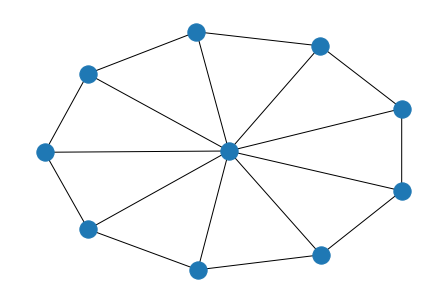

In [29]:
my_pos = nx.spring_layout(G_nx, seed = 1)
nx.draw(G_nx, pos=my_pos)

In [30]:
G=MyGraph()
G.add_edges_from(G_nx.edges)

In [31]:
list(G.edges)

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 2),
 (1, 9),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9)]

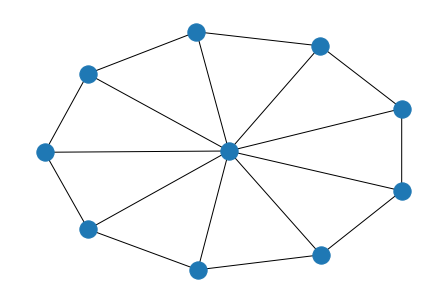

In [32]:
nx.draw(G, pos=my_pos)

In [33]:
print(nx.pagerank(G))
print(nx.katz_centrality(G))
print(nx.betweenness_centrality(G))
print(nx.triangles(G))
print(nx.density(G))

{0: 0.2324670908094764, 1: 0.08528143435450258, 2: 0.08528143435450258, 3: 0.08528143435450258, 4: 0.08528143435450258, 5: 0.08528143435450258, 6: 0.08528143435450258, 7: 0.08528143435450258, 8: 0.08528143435450258, 9: 0.08528143435450258}
{0: 0.4579565456416136, 1: 0.29632485970337064, 2: 0.29632485970337064, 3: 0.29632485970337064, 4: 0.29632485970337064, 5: 0.29632485970337064, 6: 0.29632485970337064, 7: 0.29632485970337064, 8: 0.29632485970337064, 9: 0.29632485970337064}
{0: 0.625, 1: 0.013888888888888888, 2: 0.013888888888888888, 3: 0.013888888888888888, 4: 0.013888888888888888, 5: 0.013888888888888888, 6: 0.013888888888888888, 7: 0.013888888888888888, 8: 0.013888888888888888, 9: 0.013888888888888888}
{0: 9, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2}
0.4
